In [2]:
cd '/home/user/project/python/rmsKit/'

/home/user/project/python/rmsKit


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from importlib import reload
import sys
import rms
import jax 
import numpy as np
import jax.numpy as jnp
from jax.config import config
sys.path.append("/home/user/project/python/reduce_nsp")
sys.path.append("/home/user/project/python/exact")
import nsp
import numpy as np
reload(rms)
groundstate = np.load("../exact/test/out/KH_2x2/Jx_1_Jy_1_Jz_1_h_0/groundstate.npy")


/home/user/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import jax 

In [6]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [7]:
H0 = -np.load("/home/user/project/python/rmsKit/array/KH/3site/none/Jx_1_Jy_1_Jz_1_hx_0_hz_0/H/0.npy")
H1 = -np.load("/home/user/project/python/rmsKit/array/KH/3site/none/Jx_1_Jy_1_Jz_1_hx_0_hz_0/H/1.npy")
H2 = -np.load("/home/user/project/python/rmsKit/array/KH/3site/none/Jx_1_Jy_1_Jz_1_hx_0_hz_0/H/2.npy")
U = np.load("/home/user/project/python/rmsKit/array/KH/3site/mes/Jx_1_Jy_1_Jz_1_hx_0_hz_0/M_240/u/0.npy")
H_list = [H0, H1, H2]
SH_list = [
    -nsp.utils.stoquastic(-H) for H in H_list
]

In [8]:
ur = rms.unitary.UnitaryRiemanGenerator(8, jax.random.PRNGKey(0), np.float64)

UnitaryRiemanGenerator is initialized


In [9]:
u = ur.reset_matrix()
if not rms.check_is_unitary(u):
    print("u is unitary")

In [10]:
H0.shape

(64, 64)

In [12]:
x0 = groundstate.reshape([8]*4)
x0 = x0.transpose([0,2,1,3]).reshape(-1)
x0 = jnp.array(x0)

x1 = groundstate
x1 = jnp.array(x0)

x2 = groundstate.reshape([8]*4)
x2 = x2.transpose([0,3,1,2]).reshape(-1)
x2 = jnp.array(x2)

x_list = [x0, x1, x2]


loss = rms.loss.QuasiEnergy(jnp.array(H0), x0, 8,  np.float64)

qesLoss_list = [
    rms.loss.QuasiEnergy(jnp.array(h), _x, 8 , np.float64) for h, _x in zip(H_list, x_list)
    ]
qesLoss = rms.loss.MeanMultiLoss(qesLoss_list)
# mesLoss_list = [
#     rms.loss.MinimumEnergy(jnp.array(h), 8, np.float64) for h in H_list
#     ]
# mesLoss = rms.loss.MeanMultiLoss(mesLoss_list)

upper bounds : -1.363760
target       : -1.045609


In [13]:
loss.target

Array(-0.45374004, dtype=float64)

In [14]:
loss(jnp.eye(8)) 

Array(-0.51876355, dtype=float64)

In [30]:
print(x.device_buffer.device())
print(x.device_buffer.unsafe_buffer_pointer())
y = x.reshape(2, -1)
print(y.device_buffer.device())
print(y.device_buffer.unsafe_buffer_pointer())

gpu:0
60282637824
gpu:0
60282719744


In [97]:
u = ur.reset_matrix()
u = a

In [135]:
# u = jnp.array(U)
opt_init, opt_update, get_unitary = rms.optimizer.cg(0.0003, 0.3, mesLoss)
opt_state = opt_init(ur.unitarize(a))

In [46]:
mesLoss(a)

Array(3.16071851, dtype=float64)

In [155]:
opt_init, opt_update, get_unitary = rms.optimizer.momentum(0.0003, 0.3)
opt_state = opt_init(ur.unitarize(U))

In [157]:
opt_init, opt_update, get_unitary = rms.optimizer.cg(0.0003, 0.1, mesLoss)
opt_state = opt_init(ur.unitarize(u))

In [15]:
jax.devices()

ERROR! Session/line number was not unique in database. History logging moved to new session 66


TypeError: isinstance() arg 2 must be a type or tuple of types

In [15]:
devices = jax.devices()

/home/user/miniconda3/envs/py39/lib/python3.9/site-packages/PIL/Image.py:125: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 9.3.0
Pillow version: 9.4.0
  warnings.warn(str(v), RuntimeWarning)
[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/home/user/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/user/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/user/miniconda3/envs/py39/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/use

TypeError: isinstance() arg 2 must be a type or tuple of types

In [158]:
def step(step, opt_state):
    value, grads = jax.value_and_grad(mesLoss)(get_unitary(opt_state))
    riemannian_grad = ur.riemannian_grad(u, grads)
    opt_state = opt_update(step, riemannian_grad, opt_state)
    return value, opt_state
for i in range(1000):
    value, opt_state = step(i, opt_state)
    u = get_unitary(opt_state)
    print(value)

3.0015916946511423
3.0002018155968457
3.0001176412621753
3.0000827293522976
3.0000641289934045
3.000057903643606
3.0000555114091694
3.0000541716679336
3.0000537052514917
3.0000535315793444
3.0000534568777226


KeyboardInterrupt: 

In [114]:
value, grads = jax.value_and_grad(mesLoss)(u)
riemannian_grad = ur.riemannian_grad(u, grads)

In [ ]:
t = jnp.array([0])
t

Array([0], dtype=int64)

In [18]:
from scipy import optimize

def golden(u, rg, loss, delta = 0.001, cout = False):
    def objective(t):
        return loss(jax.scipy.linalg.expm(-t*rg)@u)
    t = jnp.array(1.0)

    g = jax.grad(objective)(t)
    g2 = jax.grad(jax.grad(objective))(t)
    step = g/g2 * delta
    step = abs(step.item())
    t = 10
    for _ in range(10):
        # print(objective(step))
        if (objective(step) < objective(0)):
            while True:
                if objective(step) < objective(step*t):
                    # print(objective(0) ,objective(step), objective(step*t))
                    a = optimize.golden(objective, brack = (0, step, step*t))
                    return a
                else:
                    step *= t
        else:
            step /= t
    if cout:
        print("No local minimum found")
    a = optimize.golden(objective)


In [24]:
a = golden(u, riemannian_grad, mesLoss)

In [115]:
def objective(t):
    return mesLoss(jax.scipy.linalg.expm(-t*riemannian_grad)@u)

In [121]:
v = jax.vmap(objective, (0,), 0)
T = np.linspace(0, 0.01, 1000)
Y = v(T)

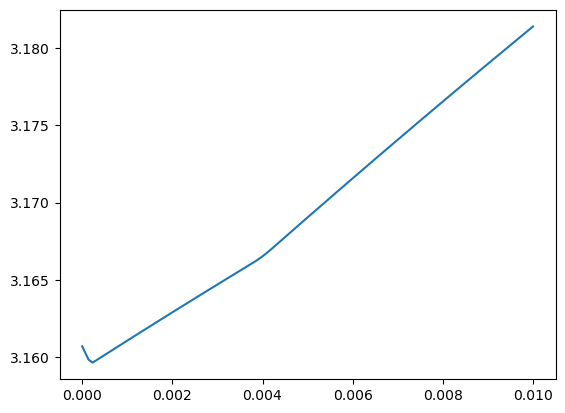

In [122]:
from matplotlib import pyplot as plt

plt.plot(T, Y)
# plt.vlines(golden(u, riemannian_grad, mesLoss), ymin = 0, ymax = 1)

In [123]:
(jnp.nan)

nan

In [14]:
golden(u, riemannian_grad, mesLoss)

0.0010209440758175122

In [40]:
ur.reset_params()
val = mesLoss(ur.matrix)
# print(val)
grad = jax.grad(mesLoss)(ur.matrix)
riemannian_grad = ur.riemannian_grad(grad)
print(riemannian_grad)



[[ 0.          0.04848574 -0.14949599 -0.12895075  0.08539086  0.21497774
  -0.30938472  0.146692  ]
 [-0.04848574  0.         -0.13104768  0.1381185   0.15857814  0.02893414
   0.03815241  0.12007688]
 [ 0.14949599  0.13104768  0.         -0.1519691   0.01669821  0.09771466
  -0.07352611  0.08505269]
 [ 0.12895075 -0.1381185   0.1519691   0.          0.14733817  0.00988164
   0.03453659  0.04185871]
 [-0.08539086 -0.15857814 -0.01669821 -0.14733817  0.          0.19016541
  -0.0569112   0.27680873]
 [-0.21497774 -0.02893414 -0.09771466 -0.00988164 -0.19016541  0.
  -0.06713462 -0.1142042 ]
 [ 0.30938472 -0.03815241  0.07352611 -0.03453659  0.0569112   0.06713462
   0.          0.17117901]
 [-0.146692   -0.12007688 -0.08505269 -0.04185871 -0.27680873  0.1142042
  -0.17117901  0.        ]]


In [15]:
jnp.linalg.norm(riemannian_grad)

Array(1.03253213e-15, dtype=float64)

## Gradient